## Klasifikasi Text Mining menggunakan Naive Bayes

# load drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/AMS2023')

Mounted at /content/drive


# install library ekphrasis

In [3]:
!pip install ekphrasis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.8 MB/s eta 0:00:00


In [4]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['email', 'percent', 'money', 'phone', 'user',
        'time', 'date', 'number'],
    # terms that will be annotated
    #annotate={"hashtag", "allcaps", "elongated", "repeated",'emphasis', 'censored'},
    annotate={"hashtag","allcaps","elongated","repeated",'emphasis','censored'},
    fix_html=True,  # fix HTML tokens

    # corpus from which the word statistics are going to be used
    # for word segmentation
    segmenter="twitter",

    # corpus from which the word statistics are going to be used
    # for spell correction
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons]
)

/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.10/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


# load library

In [5]:
import re
import string
import pandas as pd
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


# load dataset

In [6]:
df = pd.read_csv('/content/dataset_tweet_sentiment_opini_film.csv')


In [7]:
df.head()

,Id,Sentiment,Text Tweet
0,1,negative,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,negative,Film king Arthur ini film paling jelek dari se...
2,3,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,negative,Ane ga suka fast and furious..menurutku kok je...
4,5,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


karena kita hanya ingin fokus di Sentimen analysis, maka kita hanya pakai `Sentimen` sebagai target class nya **class**

In [8]:
df = df.drop(['Sentiment'], axis=1)

In [9]:
df.head()

,Id,Text Tweet
0,1,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,Film king Arthur ini film paling jelek dari se...
2,3,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,Ane ga suka fast and furious..menurutku kok je...
4,5,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


# Preprocessing

## setting fungsi

In [10]:


def bersih_data(text):
    return " ".join(text_processor.pre_process_doc(text))


def non_ascii(text):
    return text.encode('ascii', 'replace').decode('ascii')

def remove_space_alzami(text):
    return " ".join(text.split())

def remove_emoji_alzami(text):
    return ' '.join(re.sub("([x#][A-Za-z0-9]+)"," ", text).split())

def remove_tab(text):
    return text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")

def remove_tab2(text):
    return re.sub('\s+',' ',text)

def remove_rt(text):
    return text.replace('RT'," ")

def remove_mention(text):
    return ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())

def remove_incomplete_url(text):
    return text.replace("http://", " ").replace("https://", " ")

def remove_single_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

def change_stripe(text):
    return text.replace('-'," ")

def lower(text):
    return text.lower()

def remove_punctuation(text):
    remove = string.punctuation
    remove = remove.replace("_", "") # don't remove hyphens
    pattern = r"[{}]".format(remove) # create the pattern
    return re.sub(pattern, "", text)

## running preprocessing
logika main disini

In [11]:
final_string = []
for text in df['Text Tweet'].values:
    EachReviewText = ""
    proc = bersih_data(text)
    proc = remove_rt(proc)
    proc = lower(proc)
    proc = change_stripe(proc)
    proc = remove_tab(proc)
    proc = remove_tab2(proc)
    proc = non_ascii(proc)
    proc = remove_incomplete_url(proc)
    proc = remove_single_char(proc)
    proc = remove_punctuation(proc)
    proc = remove_space_alzami(proc)
    EachReviewText = proc
    final_string.append(EachReviewText)

masukkan hasil preprocessing ke kolom `step01`

In [12]:
df["step01"] = final_string

In [13]:
df.head(1)

,Id,Text Tweet,step01
0,1,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek filmnya repeated apalagi si ernest gak m...


cek jumlah dataset

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          200 non-null    int64 
 1   Text Tweet  200 non-null    object
 2   step01      200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


## hapus record yang kosong

In [15]:
df_hapus = df[~df['step01'].str.contains(" ")]

In [16]:
df_new = df[~df.isin(df_hapus)].dropna()

In [17]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          200 non-null    int64 
 1   Text Tweet  200 non-null    object
 2   step01      200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


## normalisasi kata slang

In [18]:
# token
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [19]:
def word_tokenize_wrapper(text):
  return word_tokenize(text)

In [20]:
df_new['tokens'] = df['step01'].apply(word_tokenize_wrapper)

In [21]:
df_new.head(10)

,Id,Text Tweet,step01,tokens
0,1,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek filmnya repeated apalagi si ernest gak m...,"[jelek, filmnya, repeated, apalagi, si, ernest..."
1,2,Film king Arthur ini film paling jelek dari se...,film king arthur ini film paling jelek dari se...,"[film, king, arthur, ini, film, paling, jelek,..."
2,3,@beexkuanlin Sepanjang film gwa berkata kasar ...,user sepanjang film gwa berkata kasar terus pa...,"[user, sepanjang, film, gwa, berkata, kasar, t..."
3,4,Ane ga suka fast and furious..menurutku kok je...,ane ga suka fast and furious repeated menurutk...,"[ane, ga, suka, fast, and, furious, repeated, ..."
4,5,"@baekhyun36 kan gua ga tau film nya, lu bilang...",user kan gua ga tau film nya lu bilang perang ...,"[user, kan, gua, ga, tau, film, nya, lu, bilan..."
5,6,tolong editingnya yg bagus ya. Saya sering kec...,tolong editingnya yg bagus ya saya sering kece...,"[tolong, editingnya, yg, bagus, ya, saya, seri..."
6,7,Kecewa dgn salah satu aktornya yg ternyata pen...,kecewa dgn salah satu aktornya yg ternyata pen...,"[kecewa, dgn, salah, satu, aktornya, yg, terny..."
7,8,Kecewa parah sama film the guys. Dear @raditya...,kecewa parah sama film the guys dear user sorr...,"[kecewa, parah, sama, film, the, guys, dear, u..."
8,9,Banyak yg kecewa abis nonton film ini :(,banyak yg kecewa abis nonton film ini sad,"[banyak, yg, kecewa, abis, nonton, film, ini, ..."
9,10,#TheMummy 2017 adalah film yang paling memgece...,hashtag the mummy hashtag number adalah film y...,"[hashtag, the, mummy, hashtag, number, adalah,..."


In [23]:
normalized_word = pd.read_excel("/content/kamus perbaikan kata.xlsx")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

df_new['tokens_perbaikan'] = df_new['tokens'].apply(normalized_term)

In [ ]:
df_new.head()

,Id,Text Tweet,step01,tokens,tokens_perbaikan
0,1,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek filmnya repeated apalagi si ernest gak m...,"[jelek, filmnya, repeated, apalagi, si, ernest...","[jelek, filmnya, repeated, apalagi, sih, ernes..."
1,2,Film king Arthur ini film paling jelek dari se...,film king arthur ini film paling jelek dari se...,"[film, king, arthur, ini, film, paling, jelek,...","[film, king, arthur, ini, film, paling, jelek,..."
2,3,@beexkuanlin Sepanjang film gwa berkata kasar ...,user sepanjang film gwa berkata kasar terus pa...,"[user, sepanjang, film, gwa, berkata, kasar, t...","[user, sepanjang, film, gwa, berkata, kasar, t..."
3,4,Ane ga suka fast and furious..menurutku kok je...,ane ga suka fast and furious repeated menurutk...,"[ane, ga, suka, fast, and, furious, repeated, ...","[saya, tidak, suka, fast, dan, furious, repeat..."
4,5,"@baekhyun36 kan gua ga tau film nya, lu bilang...",user kan gua ga tau film nya lu bilang perang ...,"[user, kan, gua, ga, tau, film, nya, lu, bilan...","[user, kan, saya, tidak, tau, film, nya, kamu,..."


In [24]:
df_new.iloc[0].tokens

['jelek',
 'filmnya',
 'repeated',
 'apalagi',
 'si',
 'ernest',
 'gak',
 'mutu',
 'bgt',
 'actingnya',
 'repeated',
 'film',
 'sampah']

In [25]:
df_new.iloc[0].tokens_perbaikan

['jelek',
 'filmnya',
 'repeated',
 'apalagi',
 'sih',
 'ernest',
 'tidak',
 'mutu',
 'banget',
 'actingnya',
 'repeated',
 'film',
 'sampah']

## Stopword - Menggunakan Modul NLTK

In [26]:
from nltk.corpus import stopwords
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
stopword = nltk.corpus.stopwords.words('indonesian')

def remove_stopwords(text):
  text = [word for word in text if word not in stopword]
  return text

df_new['Stop_removal'] = df_new['tokens_perbaikan'].apply(lambda x: remove_stopwords(x))
df_new

,Id,Text Tweet,step01,tokens,tokens_perbaikan,Stop_removal
0,1,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek filmnya repeated apalagi si ernest gak m...,"[jelek, filmnya, repeated, apalagi, si, ernest...","[jelek, filmnya, repeated, apalagi, sih, ernes...","[jelek, filmnya, repeated, sih, ernest, mutu, ..."
1,2,Film king Arthur ini film paling jelek dari se...,film king arthur ini film paling jelek dari se...,"[film, king, arthur, ini, film, paling, jelek,...","[film, king, arthur, ini, film, paling, jelek,...","[film, king, arthur, film, jelek, cerita, king..."
2,3,@beexkuanlin Sepanjang film gwa berkata kasar ...,user sepanjang film gwa berkata kasar terus pa...,"[user, sepanjang, film, gwa, berkata, kasar, t...","[user, sepanjang, film, gwa, berkata, kasar, t...","[user, film, gwa, kasar, bapaknya]"
3,4,Ane ga suka fast and furious..menurutku kok je...,ane ga suka fast and furious repeated menurutk...,"[ane, ga, suka, fast, and, furious, repeated, ...","[saya, tidak, suka, fast, dan, furious, repeat...","[suka, fast, furious, repeated, menurutku, jel..."
4,5,"@baekhyun36 kan gua ga tau film nya, lu bilang...",user kan gua ga tau film nya lu bilang perang ...,"[user, kan, gua, ga, tau, film, nya, lu, bilan...","[user, kan, saya, tidak, tau, film, nya, kamu,...","[user, tau, film, nya, bilang, perang, peranga..."
...,...,...,...,...,...,...
195,196,Fargo juga adaptasi dari film yang cukup berha...,fargo juga adaptasi dari film yang cukup berha...,"[fargo, juga, adaptasi, dari, film, yang, cuku...","[fargo, juga, adaptasi, dari, film, yang, cuku...","[fargo, adaptasi, film, berhasil, season, numb..."
196,197,637.000 waw ini sangat keren flm horor dng jum...,number waw ini sangat keren flm horor dng juml...,"[number, waw, ini, sangat, keren, flm, horor, ...","[number, waw, ini, sangat, keren, flm, horor, ...","[number, waw, keren, flm, horor, penonton, seg..."
197,198,@filmziarah film yang tenang dan menghanyutkan...,user film yang tenang dan menghanyutkan salut ...,"[user, film, yang, tenang, dan, menghanyutkan,...","[user, film, yang, tenang, dan, menghanyutkan,...","[user, film, tenang, menghanyutkan, bangga, mb..."
198,199,Film yg amat menarik. Kisah cinta & kesetiaan ...,film yg amat menarik kisah cinta kesetiaan yg ...,"[film, yg, amat, menarik, kisah, cinta, keseti...","[film, yang, amat, menarik, kisah, cinta, kese...","[film, menarik, kisah, cinta, kesetiaan, disaj..."


In [28]:
df_new.iloc[0].tokens_perbaikan

['jelek',
 'filmnya',
 'repeated',
 'apalagi',
 'sih',
 'ernest',
 'tidak',
 'mutu',
 'banget',
 'actingnya',
 'repeated',
 'film',
 'sampah']

In [29]:
df_new.iloc[0].Stop_removal

['jelek',
 'filmnya',
 'repeated',
 'sih',
 'ernest',
 'mutu',
 'banget',
 'actingnya',
 'repeated',
 'film',
 'sampah']

In [30]:
i=0
final_string_tokens = []
for text in df_new['Stop_removal'].values:
    EachReviewText = ""
    EachReviewText = ' '.join(text)
    final_string_tokens.append(EachReviewText)

In [31]:
df_new["step02"] = final_string_tokens

In [32]:
df_new.head()

,Id,Text Tweet,step01,tokens,tokens_perbaikan,Stop_removal,step02
0,1,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek filmnya repeated apalagi si ernest gak m...,"[jelek, filmnya, repeated, apalagi, si, ernest...","[jelek, filmnya, repeated, apalagi, sih, ernes...","[jelek, filmnya, repeated, sih, ernest, mutu, ...",jelek filmnya repeated sih ernest mutu banget ...
1,2,Film king Arthur ini film paling jelek dari se...,film king arthur ini film paling jelek dari se...,"[film, king, arthur, ini, film, paling, jelek,...","[film, king, arthur, ini, film, paling, jelek,...","[film, king, arthur, film, jelek, cerita, king...",film king arthur film jelek cerita king arthur
2,3,@beexkuanlin Sepanjang film gwa berkata kasar ...,user sepanjang film gwa berkata kasar terus pa...,"[user, sepanjang, film, gwa, berkata, kasar, t...","[user, sepanjang, film, gwa, berkata, kasar, t...","[user, film, gwa, kasar, bapaknya]",user film gwa kasar bapaknya
3,4,Ane ga suka fast and furious..menurutku kok je...,ane ga suka fast and furious repeated menurutk...,"[ane, ga, suka, fast, and, furious, repeated, ...","[saya, tidak, suka, fast, dan, furious, repeat...","[suka, fast, furious, repeated, menurutku, jel...",suka fast furious repeated menurutku jelek iya...
4,5,"@baekhyun36 kan gua ga tau film nya, lu bilang...",user kan gua ga tau film nya lu bilang perang ...,"[user, kan, gua, ga, tau, film, nya, lu, bilan...","[user, kan, saya, tidak, tau, film, nya, kamu,...","[user, tau, film, nya, bilang, perang, peranga...",user tau film nya bilang perang perangan peran...


## Stemming - Menggunakan Sastrawi

In [33]:
!pip install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 5.4 MB/s eta 0:00:00


In [34]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [35]:
final_string = []
s = ""
for sentence in df_new["step02"].values:
    filteredSentence = []
    EachReviewText = ""
    s = (stemmer.stem(sentence))
    filteredSentence.append(s)

    EachReviewText = ' '.join(filteredSentence)
    final_string.append(EachReviewText)

In [36]:
df_new["ProcessedText"] = final_string

In [37]:
df_new.head(10)

,Id,Text Tweet,step01,tokens,tokens_perbaikan,Stop_removal,step02,ProcessedText
0,1,Jelek filmnya... apalagi si ernest gak mutu bg...,jelek filmnya repeated apalagi si ernest gak m...,"[jelek, filmnya, repeated, apalagi, si, ernest...","[jelek, filmnya, repeated, apalagi, sih, ernes...","[jelek, filmnya, repeated, sih, ernest, mutu, ...",jelek filmnya repeated sih ernest mutu banget ...,jelek film repeated sih ernest mutu banget act...
1,2,Film king Arthur ini film paling jelek dari se...,film king arthur ini film paling jelek dari se...,"[film, king, arthur, ini, film, paling, jelek,...","[film, king, arthur, ini, film, paling, jelek,...","[film, king, arthur, film, jelek, cerita, king...",film king arthur film jelek cerita king arthur,film king arthur film jelek cerita king arthur
2,3,@beexkuanlin Sepanjang film gwa berkata kasar ...,user sepanjang film gwa berkata kasar terus pa...,"[user, sepanjang, film, gwa, berkata, kasar, t...","[user, sepanjang, film, gwa, berkata, kasar, t...","[user, film, gwa, kasar, bapaknya]",user film gwa kasar bapaknya,user film gwa kasar bapak
3,4,Ane ga suka fast and furious..menurutku kok je...,ane ga suka fast and furious repeated menurutk...,"[ane, ga, suka, fast, and, furious, repeated, ...","[saya, tidak, suka, fast, dan, furious, repeat...","[suka, fast, furious, repeated, menurutku, jel...",suka fast furious repeated menurutku jelek iya...,suka fast furious repeated turut jelek iya film
4,5,"@baekhyun36 kan gua ga tau film nya, lu bilang...",user kan gua ga tau film nya lu bilang perang ...,"[user, kan, gua, ga, tau, film, nya, lu, bilan...","[user, kan, saya, tidak, tau, film, nya, kamu,...","[user, tau, film, nya, bilang, perang, peranga...",user tau film nya bilang perang perangan peran...,user tau film nya bilang perang perang perang ...
5,6,tolong editingnya yg bagus ya. Saya sering kec...,tolong editingnya yg bagus ya saya sering kece...,"[tolong, editingnya, yg, bagus, ya, saya, seri...","[tolong, editingnya, yang, bagus, iya, saya, s...","[tolong, editingnya, bagus, iya, kecewa, film,...",tolong editingnya bagus iya kecewa film indone...,tolong editingnya bagus iya kecewa film indone...
6,7,Kecewa dgn salah satu aktornya yg ternyata pen...,kecewa dgn salah satu aktornya yg ternyata pen...,"[kecewa, dgn, salah, satu, aktornya, yg, terny...","[kecewa, dengan, salah, satu, aktornya, yang, ...","[kecewa, salah, aktornya, pendukung, penista, ...",kecewa salah aktornya pendukung penista agama ...,kecewa salah aktor dukung nista agama ah sabar...
7,8,Kecewa parah sama film the guys. Dear @raditya...,kecewa parah sama film the guys dear user sorr...,"[kecewa, parah, sama, film, the, guys, dear, u...","[kecewa, parah, sama, film, the, guys, dear, u...","[kecewa, parah, film, the, guys, dear, user, s...",kecewa parah film the guys dear user sorry to ...,kecewa parah film the guys dear user sorry to ...
8,9,Banyak yg kecewa abis nonton film ini :(,banyak yg kecewa abis nonton film ini sad,"[banyak, yg, kecewa, abis, nonton, film, ini, ...","[banyak, yang, kecewa, setelah, nonton, film, ...","[kecewa, nonton, film, sad]",kecewa nonton film sad,kecewa nonton film sad
9,10,#TheMummy 2017 adalah film yang paling memgece...,hashtag the mummy hashtag number adalah film y...,"[hashtag, the, mummy, hashtag, number, adalah,...","[hashtag, the, mummy, hashtag, number, adalah,...","[hashtag, the, mummy, hashtag, number, film, m...",hashtag the mummy hashtag number film memgecew...,hashtag the mummy hashtag number film memgecew...


## simpan hasil preprocessing

In [38]:
df_new.to_csv('clean_dataset_part01.csv',sep=";")

# Penataan Data

## pembagian fitur dan label

In [39]:
import pandas as pd
import numpy as np

In [40]:
dataset = pd.read_csv('clean_dataset_part01.csv',sep=";")

In [41]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        200 non-null    int64 
 1   Id                200 non-null    int64 
 2   Text Tweet        200 non-null    object
 3   step01            200 non-null    object
 4   tokens            200 non-null    object
 5   tokens_perbaikan  200 non-null    object
 6   Stop_removal      200 non-null    object
 7   step02            200 non-null    object
 8   ProcessedText     200 non-null    object
dtypes: int64(2), object(7)
memory usage: 14.2+ KB


In [42]:
dataset_feature = dataset['ProcessedText'].astype(str)

In [43]:
dataset_feature.head(10)

0    jelek film repeated sih ernest mutu banget act...
1       film king arthur film jelek cerita king arthur
2                            user film gwa kasar bapak
3      suka fast furious repeated turut jelek iya film
4    user tau film nya bilang perang perang perang ...
5    tolong editingnya bagus iya kecewa film indone...
6    kecewa salah aktor dukung nista agama ah sabar...
7    kecewa parah film the guys dear user sorry to ...
8                               kecewa nonton film sad
9    hashtag the mummy hashtag number film memgecew...
Name: ProcessedText, dtype: object

In [46]:

dataset_label = dataset['Text Tweet']

In [47]:
dataset_label.head(10)

0    Jelek filmnya... apalagi si ernest gak mutu bg...
1    Film king Arthur ini film paling jelek dari se...
2    @beexkuanlin Sepanjang film gwa berkata kasar ...
3    Ane ga suka fast and furious..menurutku kok je...
4    @baekhyun36 kan gua ga tau film nya, lu bilang...
5    tolong editingnya yg bagus ya. Saya sering kec...
6    Kecewa dgn salah satu aktornya yg ternyata pen...
7    Kecewa parah sama film the guys. Dear @raditya...
8             Banyak yg kecewa abis nonton film ini :(
9    #TheMummy 2017 adalah film yang paling memgece...
Name: Text Tweet, dtype: object

## distribusi label

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [66]:
import pandas as pd

# Assuming you have a DataFrame with a column containing text data
# For example, let's say your DataFrame is df and the column is 'text_column'

try:
    # Attempt to perform some operation that requires numeric values
    # Replace this line with the operation you are trying to perform
    # For example, let's say you want to calculate the mean of the column
    result = df['Text Tweet'].mean()

except TypeError as e:
    # Handle the TypeError, for example, print an error message
    print(f"Error: {e}")
    # You might want to handle the error by filling NaN or other suitable actions

# Continue with the rest of your code or handle the error as needed



Error: Could not convert Jelek filmnya... apalagi si ernest gak mutu bgt actingnya... film sampahFilm king Arthur ini film paling jelek dari seluruh cerita King Arthur @beexkuanlin Sepanjang film gwa berkata kasar terus pada bapaknyaAne ga suka fast and furious..menurutku kok jelek ya tu film@baekhyun36 kan gua ga tau film nya, lu bilang perang perangan/? Perang"an disebut ama rp yaoi jadi ambigu :vtolong editingnya yg bagus ya. Saya sering kecewa dgn film indonesia. Ditunggu filmnya!!Kecewa dgn salah satu aktornya yg ternyata pendukung penista agama. Ah, saya harus bersabar utk tak menonton film ini.Kecewa parah sama film the guys. Dear @radityadika sorry to say this.Banyak yg kecewa abis nonton film ini :(#TheMummy 2017 adalah film yang paling memgecewakan saya selama hidup. Yah padahal sy udh berekspektasi tinggi dan suka bgt mesir kuno.film jelek, jelas. Ga ada isinya. awal bulan ini nonton dua film Indonesia di bioskop: kartini dan critical eleven. penggambaran kartini dan ale jug

In [67]:
dataset_label.value_counts()

nah ini. coba nonton filmnya deh. asik parah                                                                                                  2
pokoknya kalian harus nonton film kartini, asli KEREN ! @LegacyPictures @Hanungbramantyo nonton di bioskop ya, bikinnya susah loh             2
Jelek filmnya... apalagi si ernest gak mutu bgt actingnya... film sampah                                                                      1
Dan film ZIARAH ini muatannya berlapis. Tentang hidup, tentang cinta, tentang sejarah, tentang misteri, banyak sekali yang bisa disimak.      1
film indonesia terbaik tahun lalu yang saya tonton. #ziarah diputar di bioskop 18 mei 2017. catat di hape, tonton di hari pertamanya.         1
                                                                                                                                             ..
Gw ekspektasinya film ini punya kekuatan narasi yg gw bisa jadiin motivasi. Tp kalimat inspiratifnya kurang banyak hehehe               

# Ekstraksi Fitur dan Machine Learning

In [52]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split

In [53]:
train_x, test_x, train_label, test_label = train_test_split(dataset_feature, dataset_label, test_size = 0.3, random_state=42)

In [54]:
test_x

95       buried film budget murah tingkat depresi tinggi
15     habis nonton the guys kecewa nonton film repea...
30     nggak salah akting prilly film danur oke oke g...
158    males2an ajak lihat the guys ngerasa duit terb...
128    kagum banget film the guys raditya dkk kocak b...
115    tambah film indonesia favorite iya hashtag cri...
69                                           film hambar
170    nysel bg nonton vlog mu the guys akhrnya bayar...
174    scene reza adinia gold moment hashtag critical...
45     nonton the mummy bilang film nya bagus bioskop...
66     bilang film jelek daur ulang gagal imdb ratatt...
182    suka film sebentar tarik hashtag dhike fact ha...
165    film film cocok lho tonton bareng anak ayo non...
78                                    film sensor hambar
186    number vlog nunggu number tanggal rilis nonton...
177    allcaps astagah allcaps allcaps film favorit l...
56                       sesal dada nonton film repeated
152    nonton film hashtag get 

## load TF-IDF

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidf_Vectorizer = TfidfVectorizer()

## Naive Bayes

In [56]:
from sklearn.naive_bayes import MultinomialNB

In [57]:
from sklearn.pipeline import Pipeline
classifier_nb = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('model', MultinomialNB()),
])

In [58]:
parameters_nb = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
    'model__alpha': (0.0001, 0.001, 0.1, 1, 10, 100)
}

In [59]:
classifier_nb = GridSearchCV(classifier_nb, parameters_nb, cv = 3, n_jobs=-1)

In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming X_train is a 1D array (e.g., a single column of a DataFrame or a pandas Series)
text_data = X_train.astype(str)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Transform the text data into TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(text_data)

# Initialize your classifier (e.g., Naive Bayes)
classifier_nb = GaussianNB()

# Fit the classifier using the TF-IDF features
classifier_nb.fit(X_train_tfidf.toarray(), y_train)


GaussianNB()

In [109]:
# Cek kolom-kolom yang ada di DataFrame
print(df.columns)

# Periksa apakah 'step01' ada di DataFrame
if 'step01' in df.columns:
    # Lakukan operasi dengan kolom 'step01'
    text_data_test = df['step01'].astype(str)
    # ... lanjutkan dengan kode Anda ...
else:
    print("Kolom 'step01' tidak ditemukan di DataFrame.")

Index(['Id', 'Text Tweet', 'step01'], dtype='object')


In [95]:
from sklearn.metrics import accuracy_score

# Make predictions on the training set
y_pred_nb_train = classifier_nb.predict(X_train_tfidf.toarray())

# Calculate accuracy on the training set
accuracy_nb_train = accuracy_score(y_train, y_pred_nb_train)
print("Accuracy Training set: ", accuracy_nb_train)


Accuracy Training set:  1.0


In [108]:
from sklearn.metrics import accuracy_score

# Make predictions on the training set
y_pred_nb_test = classifier_nb.predict(X_train_tfidf.toarray())

# Calculate accuracy on the training set
accuracy_nb_test = accuracy_score(y_train, y_pred_nb_train)
print("Accuracy Test set: ", accuracy_nb_test)

Accuracy Test set:  1.0


In [120]:
from sklearn.metrics import precision_score

# Make predictions on the training set
y_pred_nb_train = classifier_nb.predict(X_train_tfidf.toarray())

# Calculate accuracy on the training set
precision_nb_train = accuracy_score(y_train, y_pred_nb_train)
print("Precision Training set: ", precision_nb_train)

Precision Training set:  1.0


In [124]:
from sklearn.metrics import precision_score

# Make predictions on the training set
y_pred_nb_test = classifier_nb.predict(X_train_tfidf.toarray())

# Calculate accuracy on the training set
precision_nb_test = accuracy_score(y_train, y_pred_nb_test)
print("Precision Test set: ", precision_nb_test)

Precision Test set:  1.0


In [2]:
f1_nb_train = f1_score(train_label, y_pred_nb_train, average='weighted')
print("F1 Training set: ", f1_nb_train)

f1_nb_test = f1_score(test_label, y_pred_nb_test, average='weighted')
print("F1 Test set: ", f1_nb_test)

NameError: ignored

In [118]:
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(test_label, y_pred_nb_test), annot=True, cmap = 'viridis', fmt='.0f')
plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
plt.show()

ValueError: ignored

In [ ]:
classifier_nb.best_estimator_

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('model', MultinomialNB(alpha=0.1))])

In [ ]:
for param_name in sorted(parameters_nb.keys()):
    print("%s: %r" % (param_name, classifier_nb.best_params_[param_name]))

model__alpha: 0.1
tfidf__ngram_range: (1, 1)


# Visualisasi

In [ ]:
models = [
          ('Naive Bayes Multinomial', accuracy_nb_train, accuracy_nb_test),
         ]

In [ ]:
predict = pd.DataFrame(data = models, columns=['Model', 'Training Accuracy', 'Test Accuracy'])
predict

,Model,Training Accuracy,Test Accuracy
0,Naive Bayes Multinomial,0.976266,0.590406


In [ ]:
models_comparison = [
                        ('Naive Bayes Multinomial', accuracy_nb_test, recall_nb_test, precision_nb_test, f1_nb_test)
                    ]

In [ ]:
comparison = pd.DataFrame(data = models_comparison, columns=['Model', 'Accuracy', 'Recall', 'Precision', 'F1 Weighted'])
comparison

,Model,Accuracy,Recall,Precision,F1 Weighted
0,Naive Bayes Multinomial,0.590406,0.590406,0.569541,0.572316


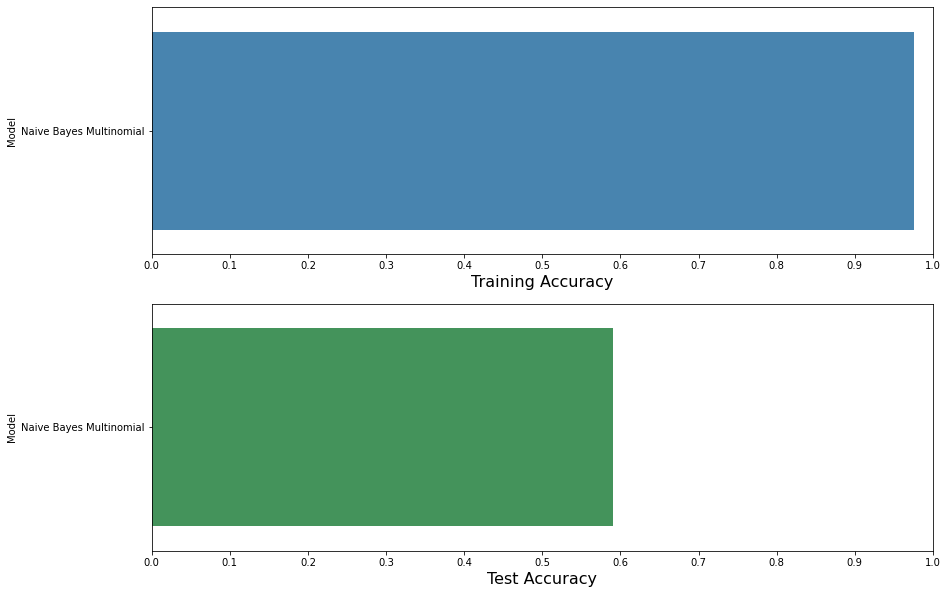

In [ ]:
import numpy as np

f, axes = plt.subplots(2,1, figsize=(14,10))

predict.sort_values(by=['Training Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Training Accuracy', y='Model', data = predict, palette='Blues_d', ax = axes[0])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[0].set_xlabel('Training Accuracy', size=16)
axes[0].set_ylabel('Model')
axes[0].set_xlim(0,1.0)
axes[0].set_xticks(np.arange(0, 1.1, 0.1))

predict.sort_values(by=['Test Accuracy'], ascending=False, inplace=True)

sns.barplot(x='Test Accuracy', y='Model', data = predict, palette='Greens_d', ax = axes[1])
#axes[0].set(xlabel='Region', ylabel='Charges')
axes[1].set_xlabel('Test Accuracy', size=16)
axes[1].set_ylabel('Model')
axes[1].set_xlim(0,1.0)
axes[1].set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

# simpan kedalam joblib

In [ ]:
import joblib

In [ ]:
# save the model to disk
joblib.dump(classifier_nb.best_estimator_, 'classifier_nb.best_estimator_.sav', compress=1)

['classifier_nb.best_estimator_.sav']